In [1]:
import nltk

In [2]:
#nltk.download_shell()

In [3]:
open('smsspamcollection/SMSSpamCollection')

<_io.TextIOWrapper name='smsspamcollection/SMSSpamCollection' mode='r' encoding='UTF-8'>

This just gives access to that file.
Let's now create a list with sms'

In [4]:
messages=[line.rstrip() for line in open('smsspamcollection/SMSSpamCollection')]

In [5]:
type(messages)

list

In [6]:
len(messages)

5574

In [7]:
for mess_no, mess in enumerate(messages[:5]):
    print(mess_no,mess)
    print('\n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...


2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


3 ham	U dun say so early hor... U c already then say...


4 ham	Nah I don't think he goes to usf, he lives around here though




In [8]:
#better use Pandas to analyze:
import pandas as pd

In [9]:
messages=pd.read_csv('smsspamcollection/SMSSpamCollection',sep='\t',names=['label','message'])

In [10]:
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [12]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [13]:
messages['length']=messages['message'].apply(len)

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<AxesSubplot:>

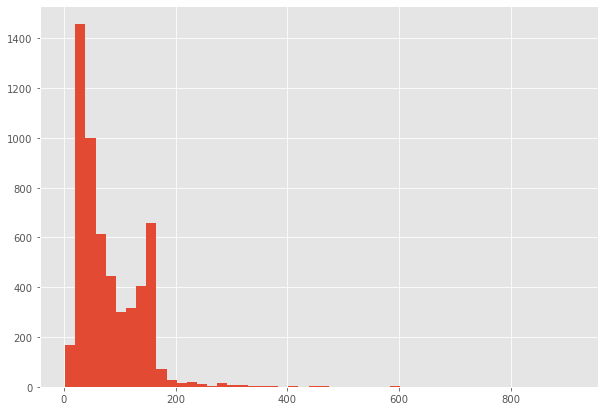

In [15]:
plt.style.use('ggplot')
plt.figure(figsize=(10,7))
messages['length'].hist(bins=50,stacked=True)

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

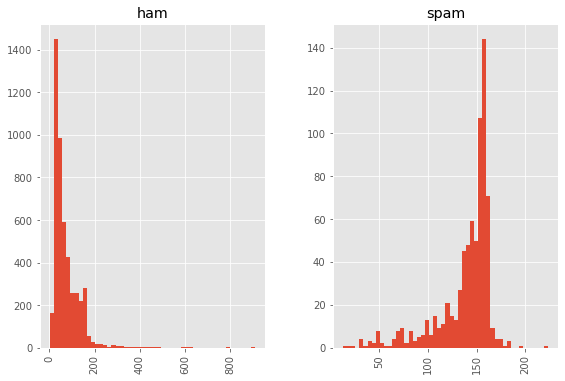

In [16]:
messages.hist(column='length',by='label',bins=50,figsize=(9,6))

It seems that spam tends to be longer than ham. Anyhow, in order to manipulate these data, we need to turn them into something ML algorithms can understand: numbers. First we will delete puntuations using Python's built-in String, then we will remove the most common words using the stopwords we previously downloaded. 

In [17]:
import string

In [18]:
mess= 'Warning! This is notice: it has puntuation.'

nopunc=[char for char in mess if char not in string.punctuation]


In [19]:
nopunc=''.join(nopunc)

In [20]:
nopunc

'Warning This is notice it has puntuation'

In [21]:
from nltk.corpus import stopwords

In [22]:
stopwords.words('english')[:5]

['i', 'me', 'my', 'myself', 'we']

In [23]:
clean_mess=[word for word in nopunc.split() if word not in stopwords.words('english')]

In [24]:
clean_mess

['Warning', 'This', 'notice', 'puntuation']

Great, let's build a function making this automatically

In [25]:
def text_process(mess):
    nopunc=[char for char in mess if char not in string.punctuation]
    nopunc=''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

Let's use this function to tokenize the messages in our dataframe

In [26]:
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

In [27]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


We now exploit the built-in CountVectorizer function to turn every single word in the whole corpus of SMS into a number (the so called Bag Of Words); then this function allows to use this correspondance to create a matrix whose line are the messages/SMS/documents of the corpus and whose column are the words of our dictionary. The number in position (i,j) will be the count of how many times the word j appears in the document i.

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

Create an istance of this function, assigning the above defined function to tokenize

In [29]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

In [30]:
print(len(bow_transformer.vocabulary_))

11425


We got thus a new object; let's experiment a bit!

In [31]:
#here's how we see the 4th message

mess4 = messages['message'][3]
print(mess4)

U dun say so early hor... U c already then say...


In [32]:
#here's how our new object sees it

bow4 = bow_transformer.transform([mess4])
print(bow4)
print(bow4.shape)

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2
(1, 11425)


So our string is turned into a matrix; only non trivial entry are printed.

In [33]:
print(bow_transformer.get_feature_names()[4068])
print(bow_transformer.get_feature_names()[9554])

U
say


which matches perfectly. So we are ready to transform the whole corpus into a matrix: 

In [34]:
messages_bow = bow_transformer.transform(messages['message'])

In [35]:
messages_bow.shape

(5572, 11425)

In [36]:
messages_bow.nnz    #number of non zero entries

50548

This is called a Sparse Matrix, which basically is a matrix whose entries are mostly zero; we can weight it via the notion of sparsity:

In [37]:
sparsity = 100*(messages_bow.nnz)/(messages_bow.shape[0]*messages_bow.shape[1])
print('sparsity is {}, which is a percentage!'.format(sparsity))

sparsity is 0.07940295412668218, which is a percentage!


Well, how can use what done so far to create a predictive model? We have to introduce two concepts:

**TF**, *Term Frequency*: given a term t in the vocabulary of a corpus of documents (that is, the set of all distinguished words appearing in the documents of the given corpus), we define
$$
\operatorname{TF}(t) =\frac{\mbox{# occurences of $t$ in the given document}}{\mbox{# terms in the given document}}
$$

which says how meaningful is the term t for the given document. Nonetheless this information has to be balanced with the **IDF**, *Inverse Document Frequency*, which measure the weight of the term t inside the whole corpus:

$$
\operatorname{IDF}(t) = \log \left(\frac{\mbox{# documents in the corpus}}{\mbox{ # documents containing $t$}}\right)
$$


which measures how peculiar the term t for the given document with respect to the corpus is: if it appears in every document, then IDT(t)=0, which say that it is not peculiar at all. 

We measure the weight of a term t inside a given document, by taking the product of the above defined quantities:

$$
\operatorname{TF}(t)\cdot \operatorname{IDF}(t)
$$

In [38]:
from sklearn.feature_extraction.text import TfidfTransformer

In [39]:
tfidf_trans = TfidfTransformer().fit(messages_bow)

Such an object 'eats' messages transformed by CountVectorizer turning them into a matrix of the same dimension, containing their weight; let's see for bow4

In [40]:
tfidf4 = tfidf_trans.transform(bow4)
print(tfidf4)

  (0, 9554)	0.5385626262927564
  (0, 7186)	0.4389365653379857
  (0, 6222)	0.3187216892949149
  (0, 6204)	0.29953799723697416
  (0, 5261)	0.29729957405868723
  (0, 4629)	0.26619801906087187
  (0, 4068)	0.40832589933384067


Let's find out the IDF for the word 'guitar' for example:

In [41]:
print(tfidf_trans.idf_[bow_transformer.vocabulary_['guitar']])

8.93254160700959


Let's transform the whole matrix:

In [42]:
mess_tfidf = tfidf_trans.transform(messages_bow)

In [43]:
mess_tfidf.shape

(5572, 11425)

We now train a model using the Naive Bayes classifier (which turns out to be good in this setting for reasons we don't explore here) fitting it with the given weights which will be evaluated to create a prediction model according with the given labels:

In [44]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(mess_tfidf,messages['label'])

In [45]:
print('predicted:', spam_detect_model.predict(tfidf4)[0])

print('expected:', messages['label'][3])

predicted: ham
expected: ham


Of course we are cheating, since we have just looked at our model on a message used to train it. In this way we have created a non supervised model which can be applied to any new message:

In [46]:
my_mess='buy cheap offer sales buy cheap offer sales buy cheap offer sales buy cheap offer sales buy cheap offer sales buy cheap offer sales buy cheap offer sales buy cheap offer sales buy cheap offer sales buy cheap offer sales buy cheap offer sales buy cheap offer sales buy cheap offer sales buy cheap offer sales buy cheap offer sales buy cheap offer sales' #words salad which very likely could be a spam smsmy_mess='  buy cheap offer sales buy cheap offer sales buy cheap offer sales buy cheap offer sales buy cheap offer sales buy cheap offer sales buy cheap offer sales buy cheap offer sales buy cheap offer sales buy cheap offer sales buy cheap offer sales buy cheap offer sales buy cheap offer sales buy cheap offer sales buy cheap offer sales buy cheap offer sales' #words salad which very likely could be a spam sms

In [47]:
my_mess_bow = bow_transformer.transform([my_mess])

In [48]:
my_mess_tfidf = tfidf_trans.transform(my_mess_bow)

In [49]:
print('prediction for my message:', spam_detect_model.predict(my_mess_tfidf)[0])

prediction for my message: ham


Well, it doesn't work with my own message; let's split the dataset in order to see how good the model is:

In [50]:
from sklearn.metrics import classification_report

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
msg_train, msg_test, label_train, label_test = train_test_split(messages['message'], messages['label'], test_size=0.2)

Let's put all together in a pipeline which will make all the work done so far in one shot (including the training/test part, which is the only thing left out):

In [53]:
from sklearn.pipeline import Pipeline

In [54]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB()),
])

'bow', 'tfidf', 'classifier' are just strings, but we need them.

In [55]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x14774edc0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [56]:
pred = pipeline.predict(msg_test)

In [57]:
print(classification_report(pred,label_test))

              precision    recall  f1-score   support

         ham       1.00      0.96      0.98      1006
        spam       0.75      1.00      0.86       109

    accuracy                           0.97      1115
   macro avg       0.88      0.98      0.92      1115
weighted avg       0.98      0.97      0.97      1115



Despite my message above, it seems a good model!